In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# !pip install catboost
# !pip install xgboost
# !pip install lightgbm

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.simplefilter(action='ignore', category=Warning)

In [4]:
df = pd.read_csv("diabetes.csv")

In [5]:
y = df["Outcome"]

In [6]:
X = df.drop(["Outcome"], axis=1)

In [8]:
rf_model = RandomForestClassifier(random_state=17)

In [9]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [11]:
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [12]:
cv_results['test_accuracy'].mean()

0.753896103896104

In [13]:
cv_results['test_f1'].mean()

0.6190701534636385

In [14]:
cv_results['test_roc_auc'].mean()

0.8233960113960114

In [15]:
rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}

In [16]:
rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}

In [17]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [18]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 8,
 'n_estimators': 500}

In [19]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

In [20]:
cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [21]:
cv_results['test_accuracy'].mean()

0.766848940533151

In [22]:
cv_results['test_f1'].mean()

0.6447777811143756

In [23]:
cv_results['test_roc_auc'].mean()

0.8271054131054132

In [24]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

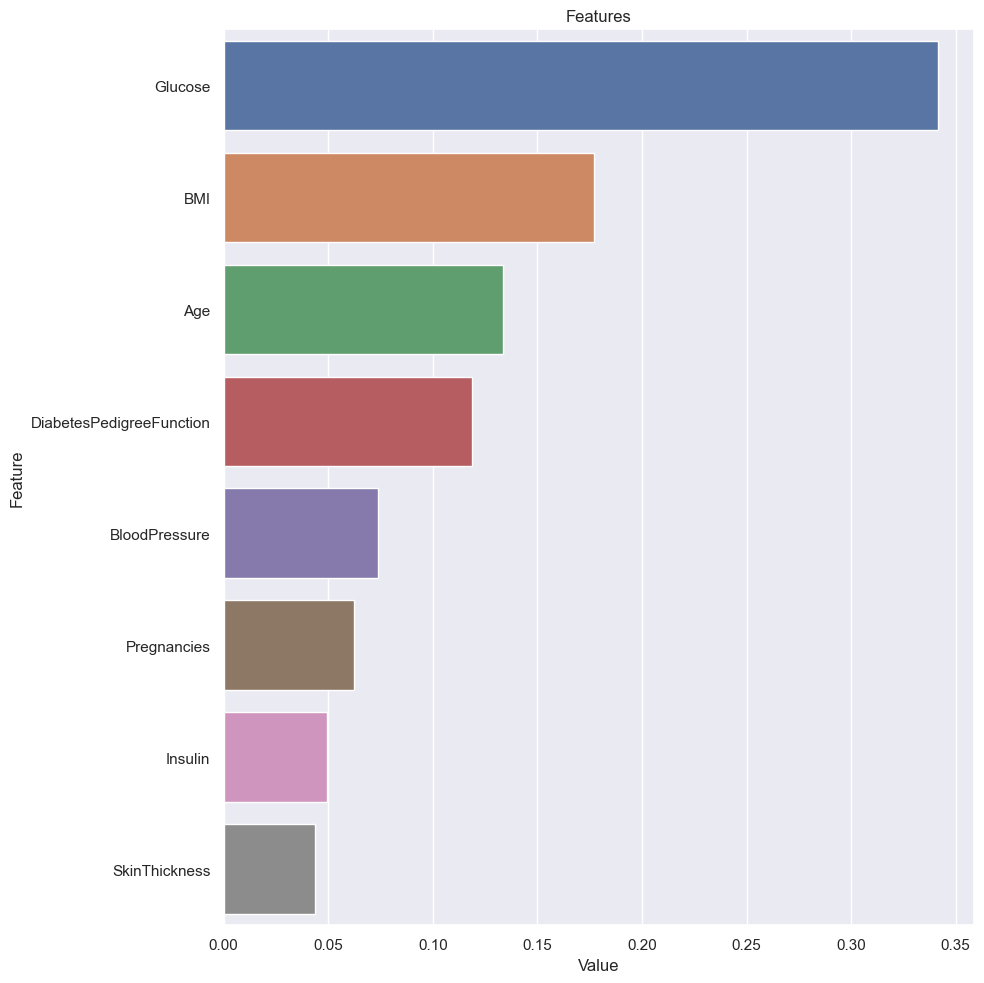

In [25]:
plot_importance(rf_final, X)

In [26]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')
    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')
    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

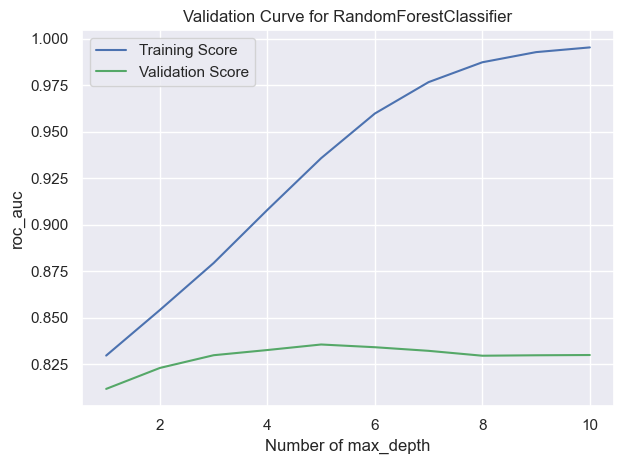

In [27]:
val_curve_params(rf_final, X, y, "max_depth", range(1, 11), scoring="roc_auc")